In [1]:
import tensorflow as tf

In [2]:
import zipfile
import os
import tensorflow as tf


In [4]:
# Specify the path to the ZIP file and the destination folder
zip_file_path = r"C:\Users\LENOVO\Desktop\archive.zip"
extract_folder = r"C:\Users\LENOVO\Desktop\extracted_files"

# Create the destination folder if it doesn't exist
os.makedirs(extract_folder, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)


In [5]:
# Specify the path to the extracted dataset
dataset_path = os.path.join(extract_folder, "Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset")

# Create the dataset using image_dataset_from_directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    batch_size=32,
    image_size=(299, 299),
)

# Get the class names (labels)
labels = dataset.class_names
print(labels)


Found 6918 files belonging to 80 classes.
['Aloevera', 'Amla', 'Amruthaballi', 'Arali', 'Astma_weed', 'Badipala', 'Balloon_Vine', 'Bamboo', 'Beans', 'Betel', 'Bhrami', 'Bringaraja', 'Caricature', 'Castor', 'Catharanthus', 'Chakte', 'Chilly', 'Citron lime (herelikai)', 'Coffee', 'Common rue(naagdalli)', 'Coriender', 'Curry', 'Doddpathre', 'Drumstick', 'Ekka', 'Eucalyptus', 'Ganigale', 'Ganike', 'Gasagase', 'Ginger', 'Globe Amarnath', 'Guava', 'Henna', 'Hibiscus', 'Honge', 'Insulin', 'Jackfruit', 'Jasmine', 'Kambajala', 'Kasambruga', 'Kohlrabi', 'Lantana', 'Lemon', 'Lemongrass', 'Malabar_Nut', 'Malabar_Spinach', 'Mango', 'Marigold', 'Mint', 'Neem', 'Nelavembu', 'Nerale', 'Nooni', 'Onion', 'Padri', 'Palak(Spinach)', 'Papaya', 'Parijatha', 'Pea', 'Pepper', 'Pomoegranate', 'Pumpkin', 'Raddish', 'Rose', 'Sampige', 'Sapota', 'Seethaashoka', 'Seethapala', 'Spinach1', 'Tamarind', 'Taro', 'Tecoma', 'Thumbe', 'Tomato', 'Tulsi', 'Turmeric', 'ashoka', 'camphor', 'kamakasturi', 'kepala']


In [6]:
import numpy as np

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    break

(32, 299, 299, 3)
[73 52 54 38 14 40 69 31 33 51  7 17 15  7 18 36 10 36 14 34 54 58  8 48
 49 37 42 29 62  7  5 40]


In [7]:
# train test split
train_size = int(0.8 * len(dataset))
test_size = int(0.2 * len(dataset))
train_size, test_size

(173, 43)

In [8]:
def get_dataset_partisions_tf(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * len(ds))
    test_size = int(test_split * len(ds))
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    val_ds = test_ds.skip(test_size)
    test_ds = test_ds.take(test_size)
    return train_ds, test_ds, val_ds

In [9]:
train_ds, test_ds, val_ds = get_dataset_partisions_tf(dataset)
len(train_ds), len(test_ds), len(val_ds)

(173, 43, 1)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(299, 299),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [11]:
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    input_shape=(299, 299, 3),
    include_top=False,
    pooling='avg',
    classifier_activation='softmax',
    classes=len(labels)
)

In [12]:
base_model.trainable = False

inputs = tf.keras.Input(shape=(299, 299, 3))
x = resize_and_rescale(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(labels), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=20
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                10320     
                                                                 
Total params: 22075376 (84.21 MB)
Trainable params: 272592 (

In [14]:
model.save(r"c:\Users\LENOVO\Desktop\modelv1.h5")

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
model_path = r"c:\Users\LENOVO\Desktop\modelv1.h5"  # Specify the local path to your saved model file

# Load the model from the specified local path
model = tf.keras.models.load_model(model_path)


In [ ]:
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '100.jpg', target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

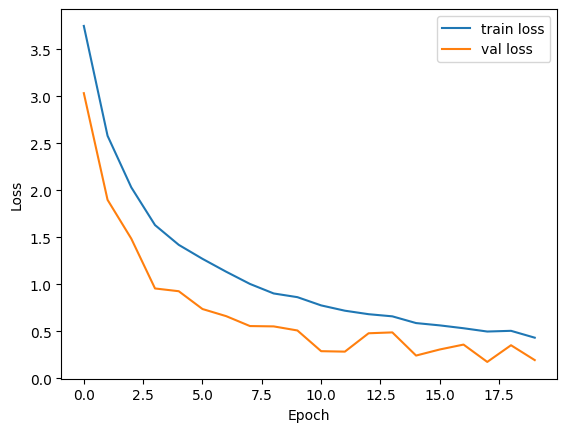

<Figure size 640x480 with 0 Axes>

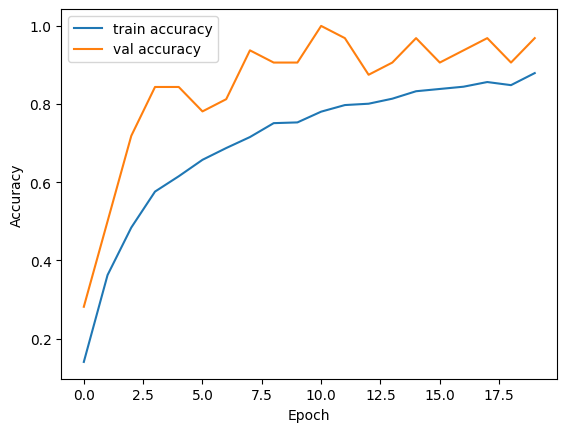

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

def plot_metrics(history, metric, save_path):
    """
    Plots a given metric (e.g. loss, accuracy) from the training history.
    
    Parameters:
    history (tf.keras.callbacks.History): Training history object returned by model.fit().
    metric (str): The name of the metric to plot ('loss' or 'accuracy').
    save_path (str): File path where the plot will be saved.
    """
    plt.figure()
    plt.plot(history.history[metric], label=f'train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'val {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()
    plt.savefig(save_path)

# Plot and save the loss and accuracy graphs
plot_metrics(history, 'loss', 'LossVal_loss.png')
plot_metrics(history, 'accuracy', 'AccVal_acc.png')